# Sentiment Analysis of Amazon Shoe Reviews

# Table of Contents
## [Introduction to the problem](#Intro)
## [Methodology](#Method)
## [Notebook Introduction](#Intro2)
## [Cleaning the dataset](#Clean)
### [Cleaning Null and Duplicates](#Null)
### [Removing Non-Shoe Products](#Remove)
#### [Method 1: Using Embeddings and Clustering](#Method1)
#### [Method 2: Manual Removal](#Method2)
## [Next Steps](#Method2)

<a id=Intro></a>
## Introduction to the problem
The purpose of this project is to create a prediction system for the rating score of a shoe review based on the sentiment of a customer's review. The dataset to be used in this project are from Amazon reviews of shoes which were collected in 1995 to 2015 stored on an S3 bucket (More info here: https://s3.amazonaws.com/amazon-reviews-pds/readme.html). The reason for picking shoes was because after performing modeling, certain key features of a shoe can be picked out from the model to determine what features consumers mainly liked about the shoes and what problem consumers hate about the shoes. This could be used by businesses to see what key features of a shoe do consumers look forward to and thus use those features when desigining a shoe.

<a id=Method></a>
## Methodology
The dataset contains over 4 million rows so checking and cleaning for null and duplicate rows will be needed. After which, basic exploratory data analysis will be performed to get some understanding of the dataset. Then, the dataset will need to be transformed to better fit text analysis and NLP such that string of texts are converted to numerical data that can be fed into the machine learning models. For simplicity, reviews will also be categorized into 2 classes rather than 5 such that 1-4 star reviews are 'bad reviews' and 5 star reviews are 'good reviews'. The models that will be used in this project is `Logistic Regression`, `SVM`, standalone `XGBoost` and `Neural Network` (pre-trained BERT with finetuning for Amazon shoe reviews).

<a id=Intro2></a>
## Notebook Introduction

The purpose of this notebook is to clean, preprocess and do basic exploratory data analysis of the dataset. 

First thing to do is to load the dataset into a dataframe.

In [2]:
# importing necessary libraries
# pickle for faster loading of file
import pickle
# os to check files and paths
import os

# libraries for exploration 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
# from sklearn.model_selection import train_test_split

In [2]:
%%time
# Loading the tsv/pickle into a dataframe
# check if the pkl file of the dataframe exists 
if (os.path.isfile('shoes.pkl')):
    # load if it exists
    with open('shoes.pkl', 'rb') as f:
        df = pickle.load(f)
else:
    # if it doesn't exist, load the tsv into df and save into pkl file for future use
    file_path = 'Shoes.tsv'
    df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')

    with open('shoes.pkl', 'wb') as f:
        pickle.dump(df, f)

CPU times: user 3.82 s, sys: 2.67 s, total: 6.48 s
Wall time: 6.61 s


## Data Prep

Exploring the dataframe to get a better understanding of the dataset and its columns.

In [3]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,108364,R2NZXYIVCGB13W,B00XFBPOQG,448483263,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,45449350,R2EQ1TG9IT3OEQ,B00SW64Y9W,7853171,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358815,US,49734568,R2C0JM229QZS0R,B000035X8T,249415522,Fox Men's Featherlite Shoe Lace-Up,Shoes,4,1,6,N,N,Get it All,If you are a fan of &quot;extreme sports&quot;...,2000-04-07
4358816,US,51790352,R3CBWUG8E05BFU,B00000J067,125201678,Floor Spinner,Shoes,1,5,5,N,N,Looks can be deceiving,This toy has gotten rave reviews from adults b...,2000-01-27
4358817,US,50804984,RN7TB51V24XHT,B00000J067,125201678,Floor Spinner,Shoes,4,7,7,N,N,My seven month old loves this toy!,My seven month old son loves to watch me shake...,1999-12-03
4358818,US,50704055,R22CRGBKA02SPB,B00000J067,125201678,Floor Spinner,Shoes,5,3,3,N,N,What a wonderful toy!,All three of my children have enjoyed watching...,1999-12-01


Looking at the table above, there is are products that aren't just shoes like "Floor Spinner" and "Anne Klein Perfect Pair Wristlet". Therefore, this suggests that the dataset is actually not just shoes as was claimed but has other products mixed in from when the data was collected. These will need to be cleaned and removed before modeling otherwise it could add noise and cause inaccuracy. This process will be left towards the end of this notebook and will proceed with the regular cleaning of the dataset.

In [4]:
df.shape

(4358820, 15)

There are 4358820 rows and 15 columns to the dataset. 

There are columns that are just identifiers so these columns are unnecessary to this report and can be dropped. Those columns are customer_id, review_id, product_id, and product_parent.

In [5]:
# Dropping ID columns
df.drop(columns=['customer_id', 'review_id', 'product_id', 'product_parent'], inplace=True)

In [6]:
# Sanity Check
df.head()

,marketplace,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31


Next, exploring the specific columns for insight.

In [7]:
df['marketplace'].value_counts()

US    4358820
Name: marketplace, dtype: int64

Since there is only 1 value for marketplace, this column can be dropped as well.

In [8]:
df.drop(columns='marketplace', inplace=True)

In [9]:
# sanity check
df.sample()

,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2989780,Bogs Men's Roper Winter Snow Boot,Shoes,5,0,0,N,Y,Like the style of the boot,When ordering went up a size. Likes the way t...,2014-01-01


In [10]:
df.product_title.nunique()

540139

There are over 540139 unique products but there are still non-shoe products to be removed. 

In [11]:
df['product_category'].value_counts()

Shoes    4358820
Name: product_category, dtype: int64

Similar to marketplace, there is only 1 value so this column can be dropped as well.

In [12]:
df.drop(columns='product_category', inplace=True)

In [13]:
# Sanity Check
df.sample()

,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
3506376,evolv Women's Elektra Lace Climbing Shoe,4,2,2,N,Y,Good climbing shoe; Takes some time to break in,Bought for daughter as birthday gift. She wea...,2013-05-11


In [14]:
df['helpful_votes'].value_counts()

0       3252257
1        585647
2        203211
3        100173
4         56190
         ...   
264           1
1555          1
402           1
465           1
435           1
Name: helpful_votes, Length: 452, dtype: int64

In [22]:
# Checking percentage breakdown
(df['helpful_votes']>0).sum()/df['helpful_votes'].count()

0.2538675604865537

25.38% of reviews have helpful votes so this column can be kept as it could help in predicting star rating

In [17]:
df['total_votes'].value_counts()

0      3008323
1       675599
2       267235
3       128834
4        74630
        ...   
371          1
357          1
557          1
281          1
364          1
Name: total_votes, Length: 487, dtype: int64

In [23]:
# Checking percentage breakdown
(df['total_votes']>0).sum()/df['total_votes'].count()

0.3098308716579258

Again, 30.98% of reviews have votes so this column can be kept.

In [27]:
df['vine'].value_counts()

N    4357927
Y        893
Name: vine, dtype: int64

Looking into what vine is, it is a program for being a top reviewer which explains the low amount of Y values compared to N. This column can be dropped since it's not significantly large enough to help create a prediction system.

In [40]:
df = df.drop(columns='vine')

In [28]:
df['verified_purchase'].value_counts()

Y    3937353
N     421467
Name: verified_purchase, dtype: int64

In [31]:
# Checking percentage breakdown
(df['verified_purchase'] == 'Y').value_counts()/df.shape[0]

True     0.903307
False    0.096693
Name: verified_purchase, dtype: float64

Although the value N might be low, it's still ~10% of the data which could help in prediction so this column can be kept. The values will have to be converted from Y to 1 and N to 0 for modeling.

In [37]:
# Converting to numeric column
df['verified_purchase'] = np.where(df['verified_purchase']=='Y',1, 0)

/var/tmp/ipykernel_953731/3618423303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_purchase'] = np.where(df['verified_purchase']=='Y',1, 0)


In [41]:
# Sanity Check
df.sample()

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date
405325,Tamarac by Slippers International Men's Suede ...,5,0,0,0,Great Quality - runs a tad small,My Dad really liked these slippers - having to...,2015-06-24


In [42]:
df['review_date'].value_counts()

2014-09-14    14010
2015-06-03    12067
2014-12-29    10618
2014-12-30    10016
2015-01-13     9146
              ...  
2005-05-05        1
2003-10-21        1
2005-04-30        1
2005-02-26        1
1999-11-08        1
Name: review_date, Length: 4483, dtype: int64

Next, `review_date` should be converted to `year` and `month` column for time series analysis and modeling so `review_date` should be in a datetime format instead of object. 

In [43]:
# converting object to datetime
df['review_date'] = df['review_date'].astype('datetime64')

In [44]:
df['year'] = df['review_date'].dt.year

In [45]:
df['month'] = df['review_date'].dt.month

In [46]:
# Now that there is a year and month column, review_date can be dropped 
df = df.drop(columns='review_date')

In [49]:
# Sanity check
df.sample()

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
3864576,Easy Spirit Women's Traveltime Mule,5,1,1,0,Easy on the feet.,The best thing about this shoe was I wore them...,2012,10


Now that every column of the independent variables have been explored, next step is to clean starting with null and duplicates, then to get rid of non-shoe products before exploring the target variable `star_rating`.

<a id=Clean></a>
## Cleaning the dataset

<a id=Null></a>
### Null and duplicates

In [ ]:
# Check for nulls
df.isna().sum()

product_title          1
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       26
review_body          440
review_date           21
dtype: int64

In [ ]:
(df.isna().sum())/df.shape[0]

product_title        2.294199e-07
star_rating          0.000000e+00
helpful_votes        0.000000e+00
total_votes          0.000000e+00
vine                 0.000000e+00
verified_purchase    0.000000e+00
review_headline      5.964917e-06
review_body          1.009448e-04
review_date          4.817818e-06
dtype: float64

Since the null values are significantly smaller than the dataset, it is fine to just drop those rows that have null values without affecting the data at all.

In [ ]:
# Dropping the nulls
df = df.dropna()

In [55]:
# Sanity Check
(df.isna().sum())

product_title        0
star_rating          0
helpful_votes        0
total_votes          0
verified_purchase    0
review_headline      0
review_body          0
year                 0
month                0
dtype: int64

In [50]:
# check for duplicates
df.duplicated().sum()

1723

In [51]:
# Dropping the duplicates
df = df.drop_duplicates()

In [52]:
# Sanity Check
df.duplicated().sum()

0

Next, the non-shoe products needs to be removed from the dataset as it will add noise to the prediction system. 

### Removing Non-Shoe Products

The first method that is going to be applied to try to remove non-shoe products is by using embeddings. A transformer from Hugging Face will be applied to each product name to hopefully convert them into vectors and similar products (i.e. shoe products) would be vectors that are similar to each other. Then, clustering could be applied to these vectors and the clusters would cluster the vectors based on shoe and non-shoe products. As will be seen later, this did not perform as expected so another method was needed after (plain old manual removal). 

#### Method 1: Embedding and Clustering

3 different embedders were used to transform and cluster but only one was kept which was `bert-base-cased` as it performed the best.

In [60]:
from sentence_transformers import SentenceTransformer

In [61]:
# Downloading and initializing the embedder to be used
embedder = SentenceTransformer('bert-base-cased')

No sentence-transformers model found with name /home/jupyter/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/jupyter/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fr

In [62]:
product_names = df['product_title']
product_names

0          Minnetonka Men's Double Deerskin Softsole Mocc...
1                                Teva Men's Pajaro Flip-Flop
3                  adidas Men's 10K Lifestyle Runner Sneaker
4          OverBling Sneakers for Men Casual Men Shoes Ge...
5                        MESSI 15.3 FG/AG SOCCER SHOES (8.5)
                                 ...                        
4358810                       Women's Evette Mid-Shaft Boots
4358811                  Women's Bree Suede Moc Snow Joggers
4358812                             Women's CanvasMule Shoes
4358813                      Birki's Super Birki Unisex Clog
4358815                   Fox Men's Featherlite Shoe Lace-Up
Name: product_title, Length: 3846073, dtype: object

In [ ]:
# Only using a subset of 50000 as it takes too long to embed over 4000000 rows of data. If this model performs well, will the full dataset be used
corpus = list(product_names)
corpus = corpus[0:50000]

In [64]:
%%time
# using the embedder on the product_names (corpus)
corpus_embeddings = embedder.encode(corpus)

CPU times: user 1h 6min 54s, sys: 8.5 s, total: 1h 7min 2s
Wall time: 8min 23s


In [65]:
from sklearn.cluster import KMeans

In [66]:
%%time
# Performing clustering with KMeans and 2 clusters
# Initialize the mode
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)

# Fit the model
clustering_model.fit(corpus_embeddings)

# Stroing the results for dataframe
cluster_assignment = clustering_model.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 51.9 s, sys: 23 s, total: 1min 14s
Wall time: 6.6 s


In [67]:
# Creating a dataframe to be used for exploring the data
cluster_df = pd.DataFrame(corpus, columns = ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df

,corpus,cluster
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1
1,Teva Men's Pajaro Flip-Flop,1
2,adidas Men's 10K Lifestyle Runner Sneaker,1
3,OverBling Sneakers for Men Casual Men Shoes Ge...,0
4,MESSI 15.3 FG/AG SOCCER SHOES (8.5),0
...,...,...
49995,KEEN Men's Newport H2 Sandal,1
49996,Florsheim Men's Cortland Oxford,1
49997,Saucony Women's Xodus 4 Trail Running Shoe,1
49998,Skechers Sport Women's EZ Flex Take It Easy Sl...,1


Now that the products have been clustered, a word cloud can be generated to see which products are in each cluster

In [ ]:
# Combine the corpus of cluster 0 into a string to feed into the word cloud 
wc = ' '.join([text for text in cluster_df['corpus'][cluster_df['cluster'] == 0]])
# Generating the word cloud
wordcloud0 = WordCloud(width = 900, height = 600, random_state = 1, max_font_size = 100).generate(wc)

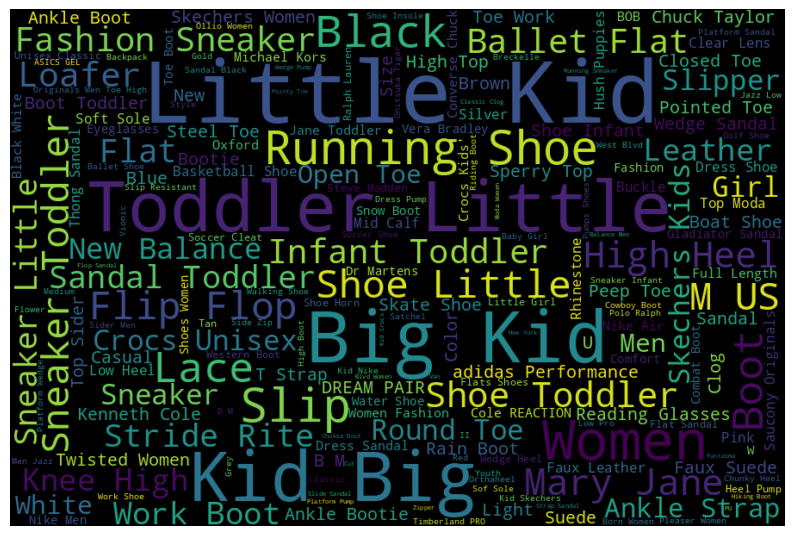

In [ ]:
# Visualizing the word cloud for cluster 0
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud0, interpolation='bilinear')
plt.axis('off')
plt.show()

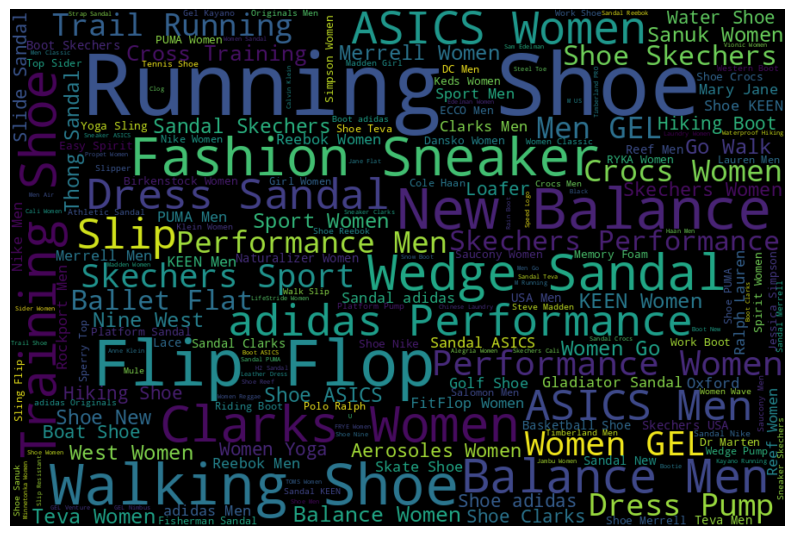

In [103]:
# Combine the corpus of cluster 1 into a string to feed into the word cloud 
wc = ' '.join([text for text in cluster_df['corpus'][cluster_df['cluster'] == 1]])
# Generating the word cloud
wordcloud1 = WordCloud(width = 900, height = 600, random_state = 1, max_font_size = 100).generate(wc)
# Displaying the word cloud
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()

As can be seen from the word cloud above, both of them contains shoes so it didn't really cluster based on non-shoe and shoe products as needed. It might be possible to use this method by labeling a subset of the dataset to help finetune the model of differentiating non-shoe and shoe products but due to time constraint, it would take too long to attempt try and get a finely tuned model to accurately cluster based on shoe and non-shoe products.  

#### Method 2: Manual Removal

Since the use of machine learning couldn't help remove non-shoe products, the other method is to remove them manually. It wouldn't be perfect as there are over 4 million rows of data but it would be possible to look at the top amounts of product reviews and remove the non-shoe products that appear on the list. 

In [16]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['product_title']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

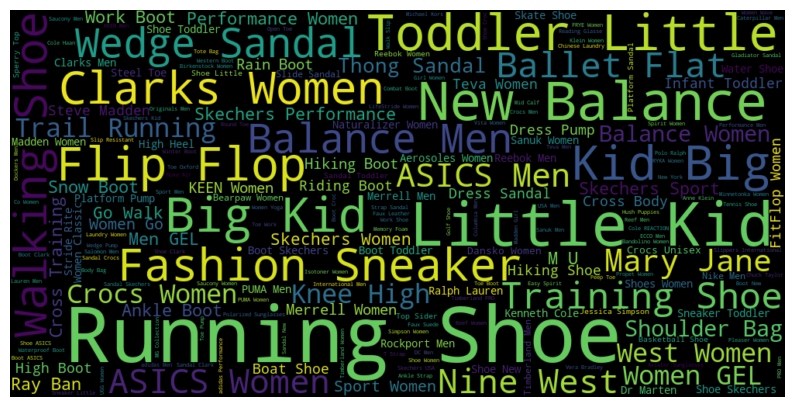

In [17]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
# Extract word frequencies from the word cloud
word_frequencies = wordcloud.words_
word_frequencies

{'Running Shoe': 1.0,
 'Little Kid': 0.5577493201752891,
 'New Balance': 0.4338985476626979,
 'Toddler Little': 0.3686149295640262,
 'Big Kid': 0.3505816846022259,
 'Kid Big': 0.33399668777133357,
 'Flip Flop': 0.3285001601592051,
 'Walking Shoe': 0.3056110244055367,
 'Fashion Sneaker': 0.3011265666637134,
 'Clarks Women': 0.29606962495484873,
 'Balance Men': 0.23766944503131623,
 'Wedge Sandal': 0.23401645209876712,
 'Training Shoe': 0.20339196750471958,
 'Ballet Flat': 0.19417770174948373,
 'ASICS Women': 0.1813070354190378,
 'Nine West': 0.17970885101104758,
 'ASICS Men': 0.17186786524817863,
 'Mary Jane': 0.1619618480327679,
 'Trail Running': 0.15870073400622917,
 'Crocs Women': 0.1580157978313762,
 'West Women': 0.15533739069986166,
 'Women GEL': 0.15493188122320742,
 'Knee High': 0.15435598961350516,
 'Shoulder Bag': 0.14987834715700374,
 'Balance Women': 0.14780650041914004,
 'Thong Sandal': 0.14604474916342372,
 'Skechers Sport': 0.14396267949757716,
 'Skechers Performance': 0.

In [57]:
# removing products that are in no way related to shoes
# regex will be used to remove complicated brands and products
common_others = [r'\bbag(s)?\b', 'sunglasses', 'wallet', r'ray[- ]?ban', 'tote', 'handbag', 'purse', 'clutch', 'spinner', 'wrist'] 
# looking for products that contain the words above and removing them
label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)
df_others=df[label_others]

/var/tmp/ipykernel_953731/1440414325.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)


In [58]:
df_others

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
2,Anne Klein Perfect Pair Wristlet,4,0,0,1,Great clutch purse!,It's perfect if you need something small for c...,2015,8
14,Travel Smart Hand Pouch Bag In Bag Organiser C...,2,1,2,1,Two Stars,It's okay .,2015,8
22,Studded Flat Top Sunglasses Bold Square DG Fas...,5,0,0,1,Five Stars,Absolutely love!!,2015,8
23,Baggallini Town Tote -Giraffe Printed,5,0,0,1,Never travel without it!!,Very sturdy. A great travel tote - lots of poc...,2015,8
36,Relic Caraway Double Shoulder Bag,5,2,2,1,I have not used it yet but it is brand new and...,It is larger than I anticipated. I have not u...,2015,8
...,...,...,...,...,...,...,...,...,...
4358814,Floor Spinner,2,0,0,0,This toy is not a must have,This toy looks like more fun than it really is...,2001,4
4358816,Floor Spinner,1,5,5,0,Looks can be deceiving,This toy has gotten rave reviews from adults b...,2000,1
4358817,Floor Spinner,4,7,7,0,My seven month old loves this toy!,My seven month old son loves to watch me shake...,1999,12
4358818,Floor Spinner,5,3,3,0,What a wonderful toy!,All three of my children have enjoyed watching...,1999,12


~500,000 rows of non-shoe products to be removed

In [59]:
# removing the products from the dataframe
df = df[~label_others]

In [60]:
# Sanity Check
df.shape[0]

3859029

In [61]:
# removing products that are close to shoes but aren't 
common_others2 = ['polish', 'laces'] 
label_others2 = df['product_title'].str.contains('|'.join(common_others2), case=False, na=False)
df_others=df[label_others2]

In [62]:
# sanity check to see if it doesn't remove any actual shoe products
df_others['product_title']

807        Round Shoelaces 3/16" Thick Solid Colors for A...
1392       LOCK LACES (Elastic No Tie Shoe Laces) (Pack o...
1399                        HICKIES Elastic No Tie Shoelaces
1525                       Kiwi Navy Shoe Polish, 1 - 1/8 oz
1764       Round Shoelaces 3/16" Thick Solid Colors for A...
                                 ...                        
4348484       Leather Shoelaces for Shoe or Boot 45" (Brown)
4349082                  Punisher - Diamond Skulls Shoelaces
4350020                                     Lock Laces(gray)
4353290            Flat Shoe Laces 45 inch, 54 inch, 63 inch
4357149                                   Boot Laces (16212)
Name: product_title, Length: 14492, dtype: object

Another ~15,000 rows of non-shoe products that can be removed.

In [63]:
# removing the rows now that it seems safe to do so
df = df[~label_others2]

In [64]:
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,1,.,Do not buy: really didn't start to wear them u...,2015,8
1,Teva Men's Pajaro Flip-Flop,5,0,0,1,super flip flop,provides great cushion as well as archsupport,2015,8
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,1,Badass,Getting what u see,2015,8
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,1,Three Stars,small,2015,8
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,1,Five Stars,My 13 year old son loved these shoes excellent...,2015,8
...,...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,0,What a waste,"I purchased this shoe because it looked good, ...",2002,10
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,0,You want it! You need it!,This little shoe-boot is so great if you're th...,2002,10
4358812,Women's CanvasMule Shoes,5,0,0,0,Cute,"The backless mule is very comfortable , cute ,...",2002,9
4358813,Birki's Super Birki Unisex Clog,5,10,11,0,Graceless and Immense - Comfy and Cool,"My garden clogs make my feet look huge, and ev...",2002,3


We have removed ~515000 rows of non-shoe data which is around ~11% of the data which may have caused problems if it was left in.

In [65]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['product_title']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

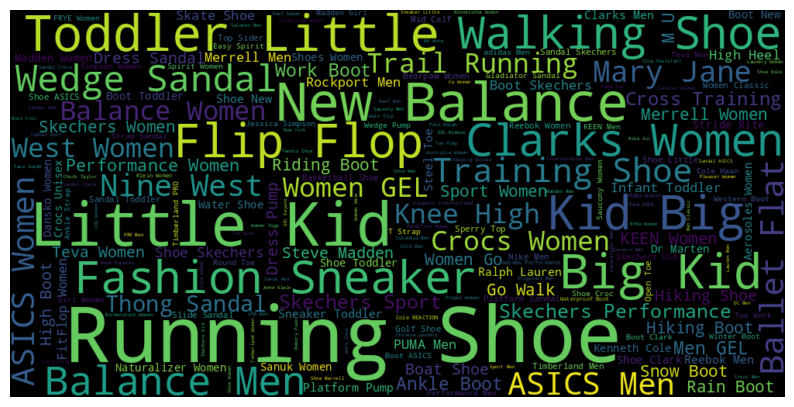

In [66]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
wordcloud.words_

{'Running Shoe': 1.0,
 'Little Kid': 0.5575427523736173,
 'New Balance': 0.4333103866627589,
 'Toddler Little': 0.3684883142376139,
 'Big Kid': 0.35045018641329906,
 'Kid Big': 0.3336355023616895,
 'Flip Flop': 0.32821009153676806,
 'Walking Shoe': 0.3054281371620194,
 'Fashion Sneaker': 0.3010285106702018,
 'Clarks Women': 0.2960597613091871,
 'Balance Men': 0.2375287117375628,
 'Wedge Sandal': 0.23397084182473743,
 'Training Shoe': 0.2034086029567126,
 'Ballet Flat': 0.1926293476556909,
 'ASICS Women': 0.1813218645419413,
 'ASICS Men': 0.17188192234028776,
 'Nine West': 0.1627248376125466,
 'Mary Jane': 0.16195464738237558,
 'Trail Running': 0.15871371415718696,
 'Crocs Women': 0.15802872196132692,
 'West Women': 0.1549684085688775,
 'Women GEL': 0.15494455311927044,
 'Knee High': 0.15390172917930436,
 'Balance Women': 0.14780495784401262,
 'Thong Sandal': 0.14605669417995187,
 'Skechers Sport': 0.1439744542213922,
 'Skechers Performance': 0.14365410961238304,
 'Cross Training': 0.14

From looking at the word cloud of the top 200 most frequent word in the dataframe, the words seems to be shoes or brands related to shoes so there doesn't seem to be any non-shoe data that stands out (and if there is, it won't be too significant as it isn't in the top 200 words)

Now that most non-shoe products have been cleaned and filtered out. The `review_headline` and `review_body` can be further analysed and cleaned if needed. To perform NLP, punctuations and special characters will be needed to be filtered out and this can be done by only looking for letters and numbers (and spaces). Then, the letters should all be converted to lower case. 

In [67]:
df[df['review_body'].str.contains(r'^[A-Za-z0-9 ]*$')]

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
1,Teva Men's Pajaro Flip-Flop,5,0,0,1,super flip flop,provides great cushion as well as archsupport,2015,8
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,1,Badass,Getting what u see,2015,8
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,1,Three Stars,small,2015,8
16,Dr. Marten's Women's 1460 Black Patent Lamper ...,5,0,0,1,Five Stars,Good,2015,8
20,RYKA Women's Vida RZX Cross-Training Shoe,4,0,0,1,Fit small,Had to return for next size Next size was com...,2015,8
...,...,...,...,...,...,...,...,...,...
4357924,adidas Men's The Hood,3,0,1,0,The hood,Well when first putting these shoes on i felt ...,2003,7
4358168,Reebok Men's Gridiron Mid,4,19,25,0,nice ...,these shoes r really nice and commfortable for...,2003,4
4358315,Nike Men's Air Pippen V,5,0,2,0,perfect,this is the most attractive shoe i have ever s...,2003,2
4358524,Timberland Women's Nellie Chukka,5,2,7,0,best boot,i like the boot verry much i cant work in them,2002,12


~340000 reviews have punctuation and special characters which need to be cleaned before vectorizing is done.

In [68]:
# Since the only characters needed are a-z and 0-9, everything else will be replaced with spaces
df['review_body'] = df.loc[:,'review_body'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()

/var/tmp/ipykernel_953731/3122726870.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_body'] = df.loc[:,'review_body'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()


In [69]:
# sanity check
df[~df['review_body'].str.contains(r'^[A-Za-z0-9 ]*$')]

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month


The same process will be applied to `review_headline`.

In [70]:
# Since the only characters needed are a-z and 0-9, everything else will be replaced with spaces
df['review_headline'] = df.loc[:,'review_headline'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()

/var/tmp/ipykernel_953731/1363393966.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_headline'] = df.loc[:,'review_headline'].str.replace(r'[^A-Za-z0-9 ]', ' ').str.lower()


In [71]:
# sanity check
df[~df['review_headline'].str.contains(r'^[A-Za-z0-9 ]*$')]

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month


Now that all the columns of independent variables have been cleaned and examined. The only thing left to explore is the target variable, `star_rating`. 

In [74]:
# Exploring the class distribution
df['star_rating'].value_counts()

5    2311816
4     763504
3     360076
2     214965
1     194176
Name: star_rating, dtype: int64

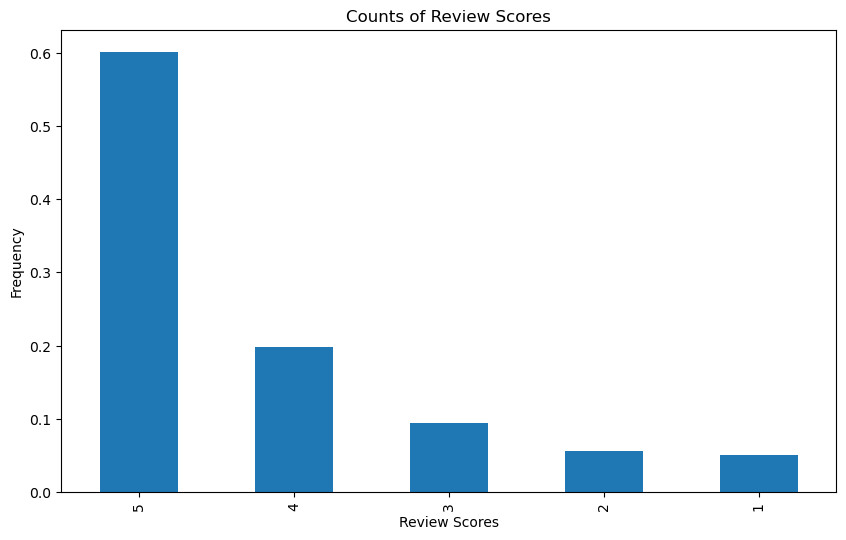

In [46]:
# Visualizing the percentage breakdown
figure = plt.figure(figsize=(10,6))
df['star_rating'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.title('Counts of Review Scores')
plt.show()

~60% of the data is 5 star reviews so there is a huge class imbalance. To tackle this, it might be better to group all reviews that aren't 5 stars together and compare with 5 star reviews. This might also work out with sentiment analysis where 5 star reviews can be seen as a perfect product (what consumers are looking for in a shoe) and anything below 5 stars could use improvement (what consumers hate the most about the shoe or feature they try to avoid).

In [75]:
# df2 will be the dataframe with 2 classes instead of 5 
df2 = df.copy()

In [76]:
# Converting 5 star ratings to 1 and anything below 5 as 0
df2['star_rating'] = np.where(df['star_rating'] < 5, 0, 1)

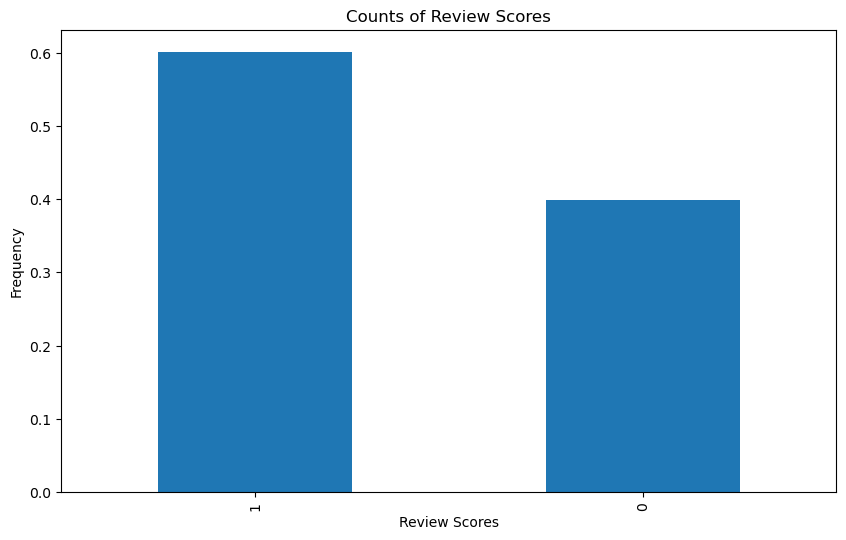

In [49]:
# Visualizing the new class distribution
figure = plt.figure(figsize=(10,6))
df2['star_rating'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.title('Counts of Review Scores')
plt.show()

Still a class imbalance of 60% to 40% which should be a decent split but could be an issue if measures aren't approriately taken (stratisfy when splitting) and maybe further downsampling if there is an issue in prediction of class 0.

In [79]:
# Code to pickle the dataframes for easier loading into other notebooks 
filename = 'df.pkl'
# Check if they already exist so it doesn't overwrite
if not os.path.isfile(filename):
    with open(filename, 'wb') as f:
        pickle.dump(df, f)
else:
    print("File already exists.")
    
filename2 = '2ClassDf.pkl'
# Code to pickle this dataframe for easier loading 
if not os.path.isfile(filename2):
    with open(filename2, 'wb') as f:
        pickle.dump(df2, f)
else:
    print("File already exists.")

<a id="next"></a>
## Next Steps

Now that the data has been cleaned and preprocessed, the next step is modeling. The next notebook, `Basic Modeling.ipynb` will be exploring the models mentioned in methodology, logistic regression, SVM, and XGBoost.